In [86]:
from pathlib import Path
import time
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device}')

using cpu


In [3]:
img_size = 784
img_shape = (28, 28)


def one_hot(n, i):
    q = np.zeros(n)
    q[i] = 1.0
    return q


class MNISTDataset(Dataset):
    def __init__(self, fp):
        xy = np.loadtxt(fp, delimiter=',', dtype=np.float32)

        self.n_samples = xy.shape[0]

        self.x = torch.from_numpy(xy[:, 1:])
        self.x = self.x / 255.0

        labels = []
        for i in xy[:, 0]:
            labels.append(one_hot(10, int(i)))
        self.y = torch.from_numpy(np.array(labels))


    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.n_samples

In [4]:
train_dataset = MNISTDataset(Path('/content/sample_data/mnist_train_small.csv'))
test_dataset = MNISTDataset(Path('/content/sample_data/mnist_test.csv'))

In [5]:
batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size)
test_dataloader = DataLoader(test_dataset, batch_size)

In [6]:
class Perceptron(nn.Module):
    def __init__(self, n_in, n_hidden):
        super().__init__()

        self.n_in = n_in
        self.n_hidden = n_hidden

        self.h1 = nn.Linear(self.n_in, self.n_hidden)
        self.h2 = nn.Linear(self.n_in, self.n_hidden)
        self.h3 = nn.Linear(self.n_in, self.n_hidden)
        self.f = nn.Sigmoid()

    def forward(self, x):
        return torch.stack([
            self.f(self.h1(x)),
            self.f(self.h2(x)),
            self.f(self.h3(x))
        ])

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()

    for (x, y) in dataloader:
        x = x.to(device)
        h = model(x)

        loss = loss_fn(h)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

In [30]:
def loss_fn(y: torch.Tensor) -> torch.Tensor:
    t = torch.ones(len(y), *y.shape)*y
    t = y.unsqueeze(1)*torch.log(t)
    y = torch.sum(3*y*torch.log(y), dim=1)
    t = torch.sum(torch.sum(t, dim=2), dim=1)
    return torch.sum(y-t)

In [100]:
n_in = 784
n_hidden = 16

learning_rate = 1e-3

model = Perceptron(n_in, n_hidden).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [101]:
n_eras = 4
n_epoch = 2

start_t = time.time()

for i in range(n_eras):
    w1_tmp = model.h1.weight.detach().clone()
    b1_tmp = model.h1.bias.detach().clone()

    w2_tmp = model.h2.weight.detach().clone()
    b2_tmp = model.h2.bias.detach().clone()

    w3_tmp = model.h3.weight.detach().clone()
    b3_tmp = model.h3.bias.detach().clone()

    for j in range(n_epoch):
        train(train_dataloader, model, loss_fn, optimizer)

    with torch.no_grad():
        model.h1.weight -= w1_tmp
        model.h1.bias -= b1_tmp

        model.h2.weight -= w2_tmp
        model.h2.bias -= b2_tmp

        model.h3.weight -= w3_tmp
        model.h3.bias -= b3_tmp

print(f"done ({round(time.time()-start_t, 2)} sec.)")


done (3.71 sec.)


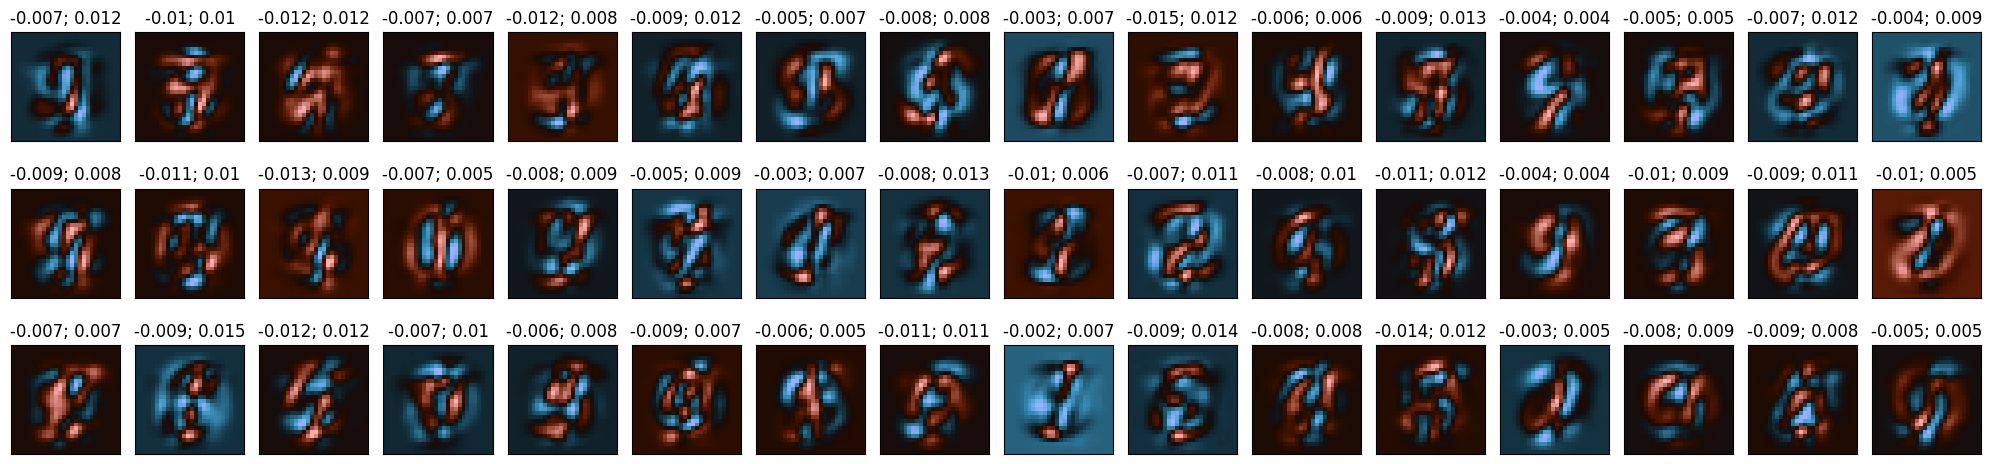

In [102]:
fig, axes = plt.subplots(nrows=3, ncols=16)

fig.set_dpi(100)
fig.set_figwidth(20)
fig.set_figheight(5)

hs = [model.h1, model.h2, model.h3]

for j in range(3):
    w = hs[j].weight.detach().numpy()

    for i, ax in enumerate(axes[j].ravel()):
        v = -1 + 2 * (w[i]-np.min(w[i]))/(np.max(w[i]-np.min(w[i])))
        img = ax.imshow(v.reshape(img_shape),  cmap='berlin')
        ax.set_title(f"{round(float(np.min(w[i])), 3)}; {round(float(np.max(w[i])), 3)}")
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
x = torch.FloatTensor([
    [1,2,3],
    [4,5,6]
])
print(x)

tensor([[1., 2., 3.],
        [4., 5., 6.]])


In [ ]:
t = torch.ones(x.shape[0], *x.shape)*x
print(t.shape)
print(t)

torch.Size([2, 2, 3])
tensor([[[1., 2., 3.],
         [4., 5., 6.]],

        [[1., 2., 3.],
         [4., 5., 6.]]])


In [ ]:
t = x.unsqueeze(1)*t
print(x.unsqueeze(1).shape)
print(x.unsqueeze(1))
print(t.shape)
print(t)

torch.Size([2, 1, 3])
tensor([[[1., 2., 3.]],

        [[4., 5., 6.]]])
torch.Size([2, 2, 3])
tensor([[[ 1.,  4.,  9.],
         [ 4., 10., 18.]],

        [[ 4., 10., 18.],
         [16., 25., 36.]]])


In [ ]:
x = torch.sum(x, dim=1)
print(x.shape)
print(x)

torch.Size([2])
tensor([ 6., 15.])


In [ ]:
t = torch.sum(t,dim=2)
print(t)

t = torch.sum(t, dim=1)
print(t)

tensor([[14., 32.],
        [32., 77.]])
tensor([ 46., 109.])


In [ ]:
y = torch.sum(x-t)
print(x-t)
print(y)

tensor([-40., -94.])
tensor(-134.)
